## Imports

In [1]:
from nb_utils import set_root

PROJECT_DIR = set_root(3)
print("PROJECT_DIR: " + str(PROJECT_DIR))

PROJECT_DIR: /home/manuel/Documents/projects/libs/mlpr


In [2]:
import numpy as np
import pandas as pd
import sklearn.datasets as sk_datasets
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
from xgboost import XGBRegressor

from mlpr.ml.supervisioned.regression import metrics, plots
from mlpr.ml.tunning.grid_search import GridSearch
from mlpr.reports.create import ReportGenerator
from utils.reader import read_file_yaml

%reload_ext autoreload

## Parameters

In [3]:
path_data = PROJECT_DIR / 'data'
path_conf = PROJECT_DIR / 'conf'
path_templates = PROJECT_DIR / 'templates'
path_assets = PROJECT_DIR / 'assets'

path_intermediate = path_data / '02_intermediate'
path_models = path_data / '04_models'
path_reports = path_data / '05_reports'

path_reports_regression = path_templates / "regression"
file_path_reports = path_reports / "report_model.html"

parameters = read_file_yaml(path_conf / 'params.yaml')

datasets = parameters["datasets"]
n_seed = parameters["experiments"]["n_seed"]

In [4]:
np.random.seed(n_seed)

## Read

In [5]:
content = getattr(sk_datasets, datasets["diabetes"]["path"])()
data = pd.DataFrame(content["data"], columns=content["feature_names"])
data["target"] = content["target"]

In [6]:
# X, y = make_regression(n_samples=data.shape[0], n_features=11, noise=20)

# data = pd.DataFrame(data=X, columns=[f'feature_{i}' for i in range(1, 11 + 1)])
# data['target'] = y

# # Gerar outliers
# n_outliers = 50
# outliers_X = np.random.normal(loc=1000, scale=400, size=(n_outliers, data.shape[1]-1))
# outliers_y = np.random.normal(loc=1000, scale=400, size=n_outliers)

# # Adicionar outliers aos dados
# data_outliers = pd.DataFrame(data=outliers_X, columns=[f'feature_{i}' for i in range(1, data.shape[1])])
# data_outliers['target'] = outliers_y

# # Concatenar os dados originais com os outliers
# data = pd.concat([data, data_outliers], ignore_index=True)

In [7]:
# X, y = make_regression(n_samples=1000, n_features=11, noise=20)

# # Quantidade de valores a serem invertidos
# n_invert = 50

# # Selecionar um subconjunto de y para inverter
# indices = np.random.choice(y.shape[0], size=n_invert, replace=False)
# y[indices] = np.max(y) - y[indices]

# # Criar DataFrame
# data = pd.DataFrame(data=X, columns=[f'feature_{i}' for i in range(1, 11 + 1)])
# data['target'] = y

## Split labels

In [8]:
X = data.drop("target", axis=1)
y = data["target"].values

## Modelling

In [9]:
models_params = {
    Ridge: {
        'alpha': [1.0, 10.0, 15, 20],
        'random_state': [n_seed]
    },
    Lasso: {
        'alpha': [0.1, 1.0, 10.0],
        'random_state': [n_seed]
    },
    SVR: {
        'C': [0.1, 1.0, 10.0],
        'kernel': ['linear', 'rbf']
    },
    RandomForestRegressor: {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 5, 10],
        'random_state': [n_seed]
    },
    GradientBoostingRegressor: {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'random_state': [n_seed]
    },
    XGBRegressor: {
        'n_estimators': [100, 200],
        'learning_rate': [0.1, 0.05, 0.01],
        'random_state': [n_seed]
    }
}

params_split = {
    'test_size': 0.25,
    'random_state': n_seed
}
params_norm = {'with_mean': True, 'with_std': True}

grid_search = GridSearch(
    X,
    y,
    params_split=params_split,
    models_params=models_params,
    normalize=True,
    params_norm=params_norm
)
grid_search.search(cv=5, n_jobs=-1)

best_model, best_params = \
    grid_search \
    .get_best_model()

## Predictions

In [10]:
data_train = pd.DataFrame(
    grid_search.X_train,
    columns=X.columns
)
data_train["y_true"] = grid_search.y_train
data_train["y_pred"] = grid_search.best_model.predict(grid_search.X_train)

## Metrics

In [19]:
k = 3
rm = metrics.RegressionMetrics(data_train, *["y_true", "y_pred"])

In [20]:
results = rm.calculate_metrics(
    ["mape", "rmse", "kolmogorov_smirnov", "confusion_matrix", "calculate_kappa"],
    {
        "mape": {},
        "rmse": {},
        "kolmogorov_smirnov": {},
        "confusion_matrix": {"n_bins": k},
        "calculate_kappa": {"n_bins": k}
    }
)

## Plots

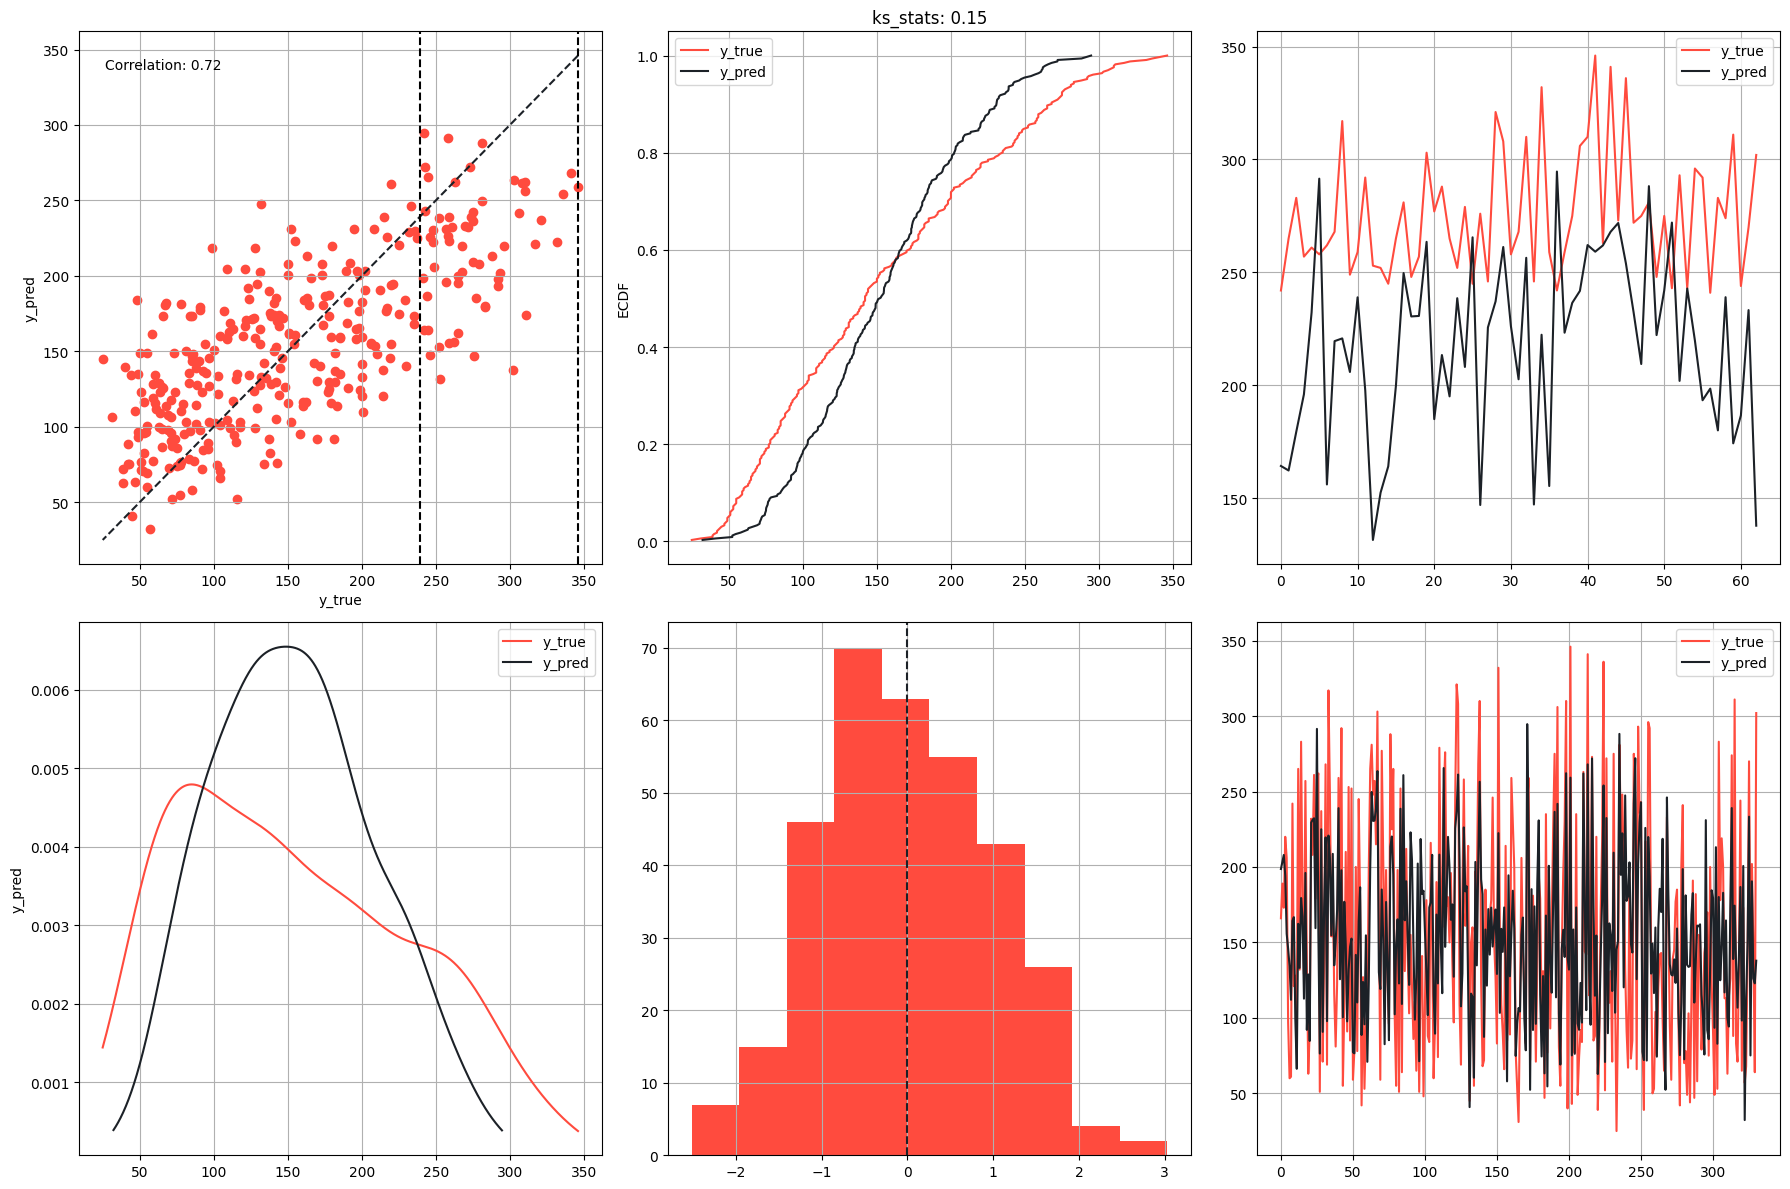

In [31]:
rp = plots.RegressionPlots(data_train, color_palette=["#FF4B3E", "#1C2127"])
fig, axs = rp.grid_plot(
    plot_functions=[
        ['graph11', 'graph12', 'graph13'],
        ['graph21', 'graph22', 'graph23'],
    ],
    plot_args={
        'graph11': {
            "plot": "scatter",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'linecolor': '#1C2127',
                'worst_interval': True,
                'metrics': rm.metrics["calculate_kappa"],
                'class_interval': rm._class_intervals,
                'method': 'recall',
                'positive': True
            }
        },
        'graph12': {
            "plot": "plot_ecdf",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred'
            }
        },
        'graph21': {
            "plot": "plot_kde",
            "params": {
                'columns': ['y_true', 'y_pred']
            }
        },
        'graph22': {
            "plot": "plot_error_hist",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'linecolor': '#1C2127'
            }
        },
        'graph13': {
            "plot": "plot_fitted",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'condition': (data_train["y_true"] >= 239.0),
                'sample_size': None
            }
        },
        'graph23': {
            "plot": "plot_fitted",
            "params": {
                'y_true_col': 'y_true',
                'y_pred_col': 'y_pred',
                'condition': None,
                'sample_size': None
            }
        },
    },
    show_inline=True
)

In [43]:
rm._class_intervals

{0: (-inf, 57.1),
 1: (57.1, 89.2),
 2: (89.2, 121.30000000000001),
 3: (121.30000000000001, 153.4),
 4: (153.4, 185.5),
 5: (185.5, 217.60000000000002),
 6: (217.60000000000002, 249.70000000000002),
 7: (249.70000000000002, 281.8),
 8: (281.8, 313.90000000000003),
 9: (313.90000000000003, inf)}

In [44]:
{i[0]: i[1]["metrics"]["precision"] for i in rm.metrics["calculate_kappa"].items()}

{0: array([0.91411043, 0.4       ]),
 1: array([0.84563758, 0.36363636]),
 2: array([0.87912088, 0.20689655]),
 3: array([0.86153846, 0.1971831 ]),
 4: array([0.8984375 , 0.14666667]),
 5: array([0.91156463, 0.18918919]),
 6: array([0.93559322, 0.25      ]),
 7: array([0.91509434, 0.23076923]),
 8: array([0.95731707, 0.        ]),
 9: array([0.98187311, 0.        ])}

## Save image

In [19]:
fig.savefig(
    path_assets / "regression_plots.png",
    dpi=400,
    bbox_inches='tight'
)

## Reports

In [18]:
report = ReportGenerator(template_dir=path_reports_regression)
report.render(
    metrics=results,
    template_file="template_v3.html",
    output_file=file_path_reports,
    image_path=path_intermediate / "regression_plots.png"
)

'Report created successfully.'